Part 1 ‐ Exploratory data analysis

The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15minute time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.


# Load packages

In [104]:
import numpy as np
import pandas as pd
import datetime
from plotnine import *
import plotnine
import warnings

plotnine.options.figure_size = (20, 10)
warnings.filterwarnings('ignore')

# Load Data

In [105]:
login_times = pd.read_json('logins.json')

# Check Data

In [106]:
login_times.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [107]:
login_times.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


Dataset just has one column for the timestamps. Nothing else. I'll need to make a numeric column, each with value 1, to group and sum the data

In [108]:
login_times[login_times.login_time.isnull()]

,login_time


There are no missing values in the data

In [109]:
print("Beginning Time Stamp: ", login_times.login_time.min(), "\n", 
      "Ending Time Stamp: ", login_times.login_time.max(), sep = "")

Beginning Time Stamp: 1970-01-01 20:12:16
Ending Time Stamp: 1970-04-13 18:57:38


Timeseries runs from 1/1/1970 - 4/13/1970

# Clean Data

I need to create some extra variables for rolling averages and datetime groupings

In [110]:
login_times = login_times.set_index("login_time").\
assign(timestamps = 1).\
sort_index().\
resample("15min").sum().\
assign(hourly_ts = lambda x: x["timestamps"].rolling(window = 4, center = True).mean().values, 
       daily_ts = lambda x: x["timestamps"].rolling(window = (4 * 24), center = True).mean().values, 
       weekly_ts = lambda x: x["timestamps"].rolling(window = (4 * 24 * 7), center = True).mean().values).\
reset_index().\
assign(hour = lambda x: x.login_time.dt.hour, 
       weekday = lambda x: x.login_time.dt.day_name().astype('category').cat.reorder_categories(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]),
       month = lambda x: x.login_time.dt.month_name().astype('category').cat.reorder_categories(["January", "February", "March", "April"]))

login_times

,login_time,timestamps,hourly_ts,daily_ts,weekly_ts,hour,weekday,month
0,1970-01-01 20:00:00,2,NaN,NaN,NaN,20,Thursday,January
1,1970-01-01 20:15:00,6,NaN,NaN,NaN,20,Thursday,January
2,1970-01-01 20:30:00,9,6.00,NaN,NaN,20,Thursday,January
3,1970-01-01 20:45:00,7,5.75,NaN,NaN,20,Thursday,January
4,1970-01-01 21:00:00,1,5.25,NaN,NaN,21,Thursday,January
...,...,...,...,...,...,...,...,...
9783,1970-04-13 17:45:00,5,5.50,NaN,NaN,17,Monday,April
9784,1970-04-13 18:00:00,5,5.25,NaN,NaN,18,Monday,April
9785,1970-04-13 18:15:00,2,4.75,NaN,NaN,18,Monday,April
9786,1970-04-13 18:30:00,7,5.00,NaN,NaN,18,Monday,April


# Data Exploration

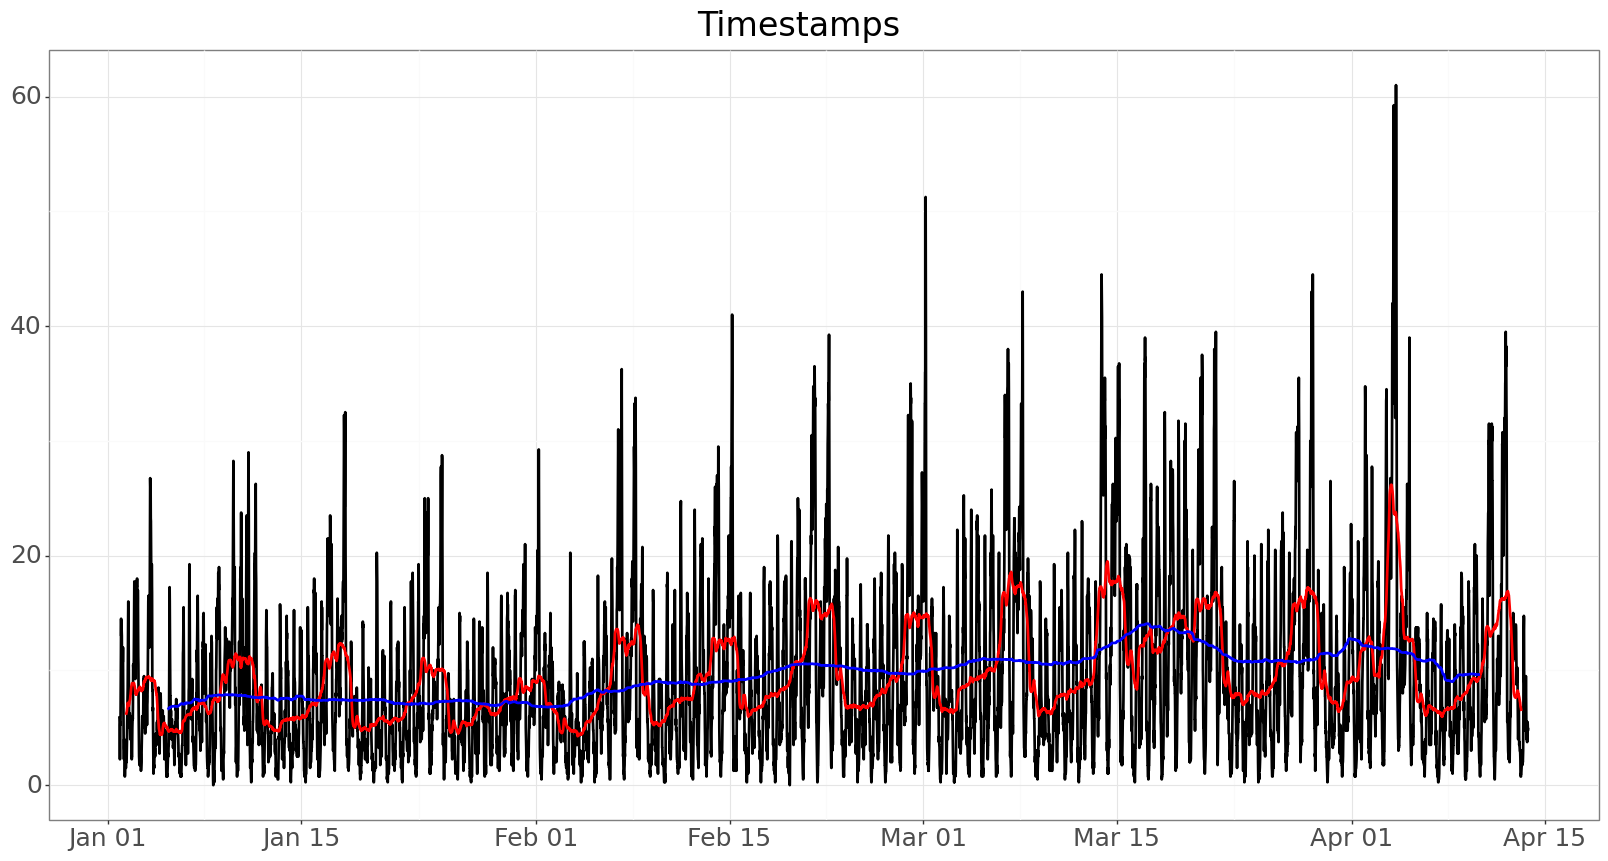

<ggplot: (118572839379)>

In [111]:
(ggplot(login_times, aes("login_time")) + 
    geom_line(aes(y = "hourly_ts"), size = 1.1, color = "black") + 
    geom_line(aes(y = "daily_ts"), size = 1.1, color = "red") + 
    geom_line(aes(y = "weekly_ts"), size = 1.1, color = "blue") + 
    scale_x_date(date_labels = "%b %d") + 
    labs(title = "Timestamps", 
         x = "", 
         y = "") + 
    theme_bw() + 
    theme(axis_text = element_text(size = 18), 
          plot_title = element_text(size = 24)))

In [112]:
The daily averages line (red) shows a seasonality

SyntaxError: invalid syntax (278240679.py, line 1)

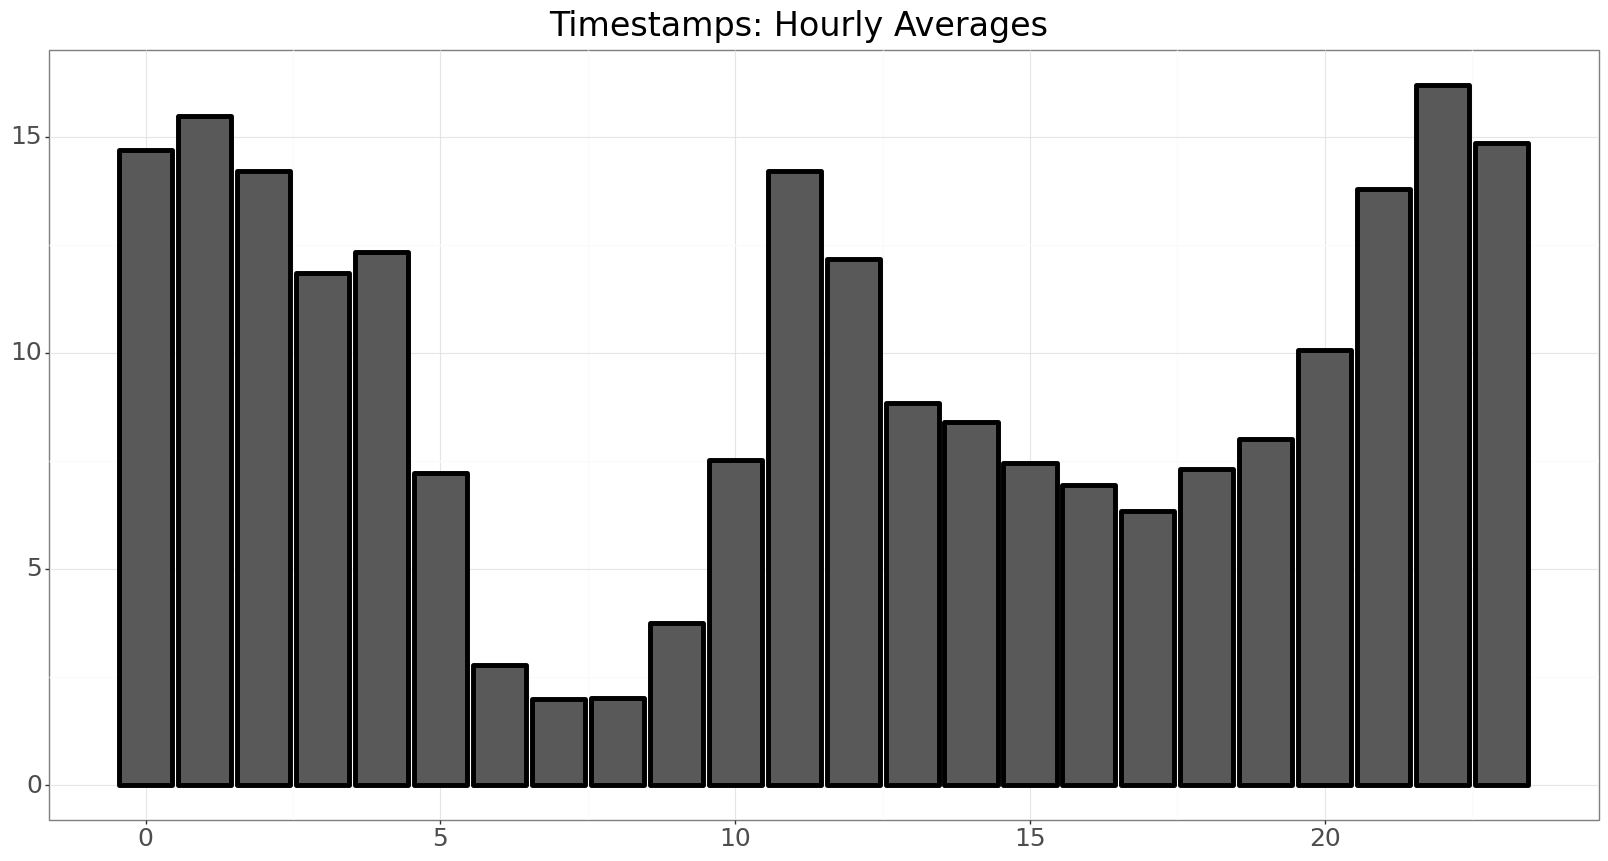

<ggplot: (118569556188)>

In [113]:
df = login_times.groupby("hour").\
       agg({"timestamps": "mean"}).\
       reset_index()

(ggplot(df, aes(x = "hour", y = "timestamps")) +
 geom_bar(stat = "identity", color = "black", size = 2) + 
 labs(title = "Timestamps: Hourly Averages", 
      x = "", 
      y = "") +
 theme_bw() + 
 theme(axis_text = element_text(size = 18), 
       plot_title = element_text(size = 24)))

Theres a peak from 11am - 12pm and 9pm-4am

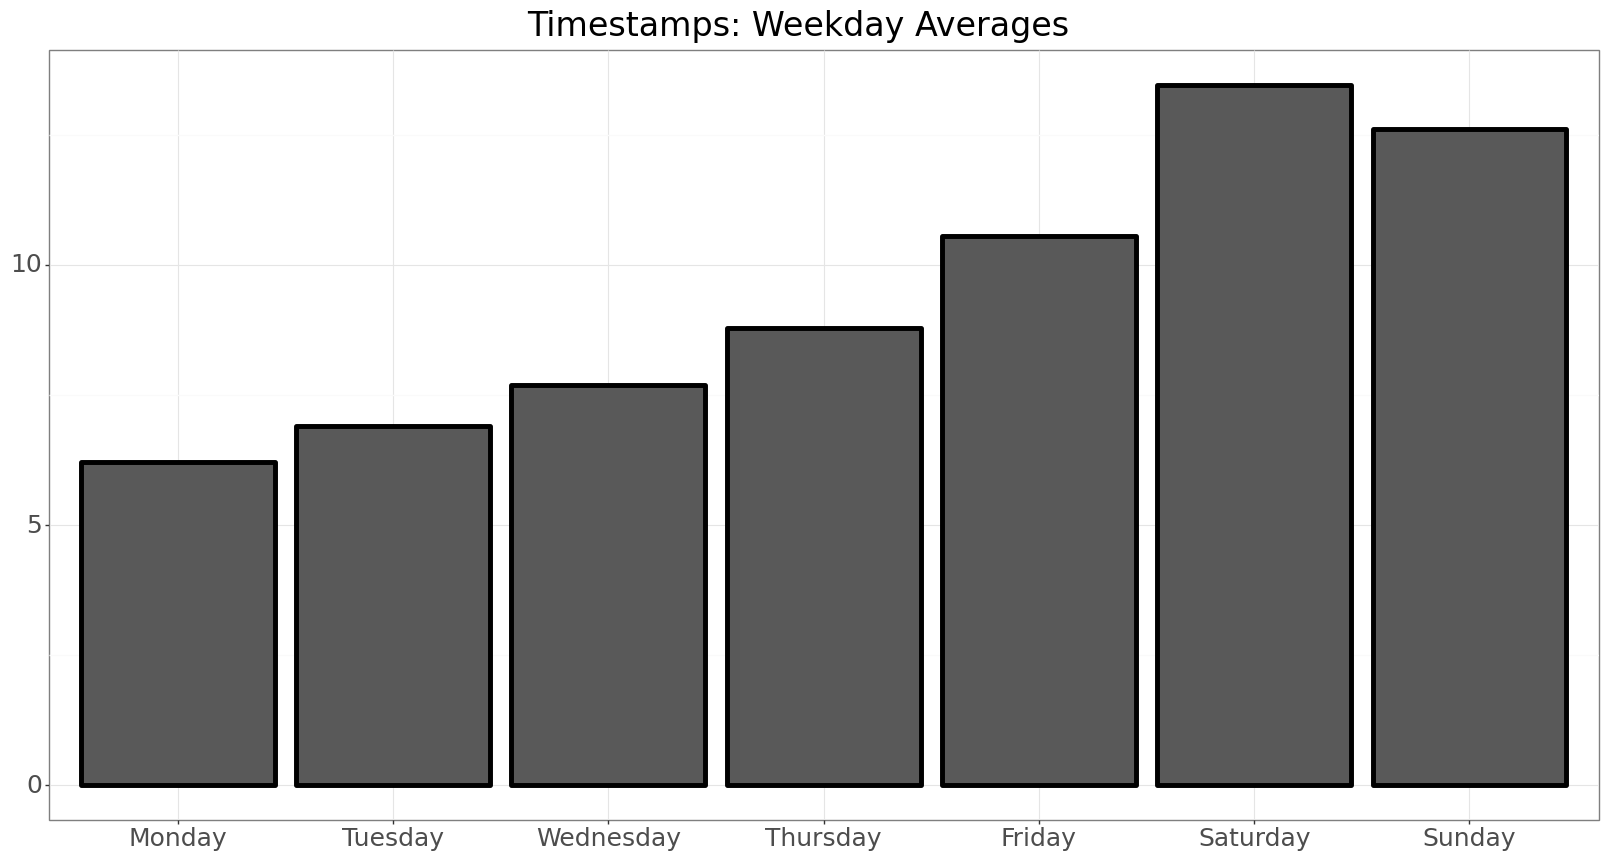

<ggplot: (118573129975)>

In [114]:
df = login_times.groupby("weekday").\
       agg({"timestamps": "mean"}).\
       reset_index()

(ggplot(df, aes(x = "weekday", y = "timestamps")) +
 geom_bar(stat = "identity", color = "black", size = 2) + 
 labs(title = "Timestamps: Weekday Averages", 
      x = "", 
      y = "") + 
 theme_bw() + 
 theme(axis_text = element_text(size = 18), 
       plot_title = element_text(size = 24)))

Each day of the week increases it gets closer to the weekend. Sunday falls off from Saturday a small bit but is stil lthe second hightest by a wide margin.

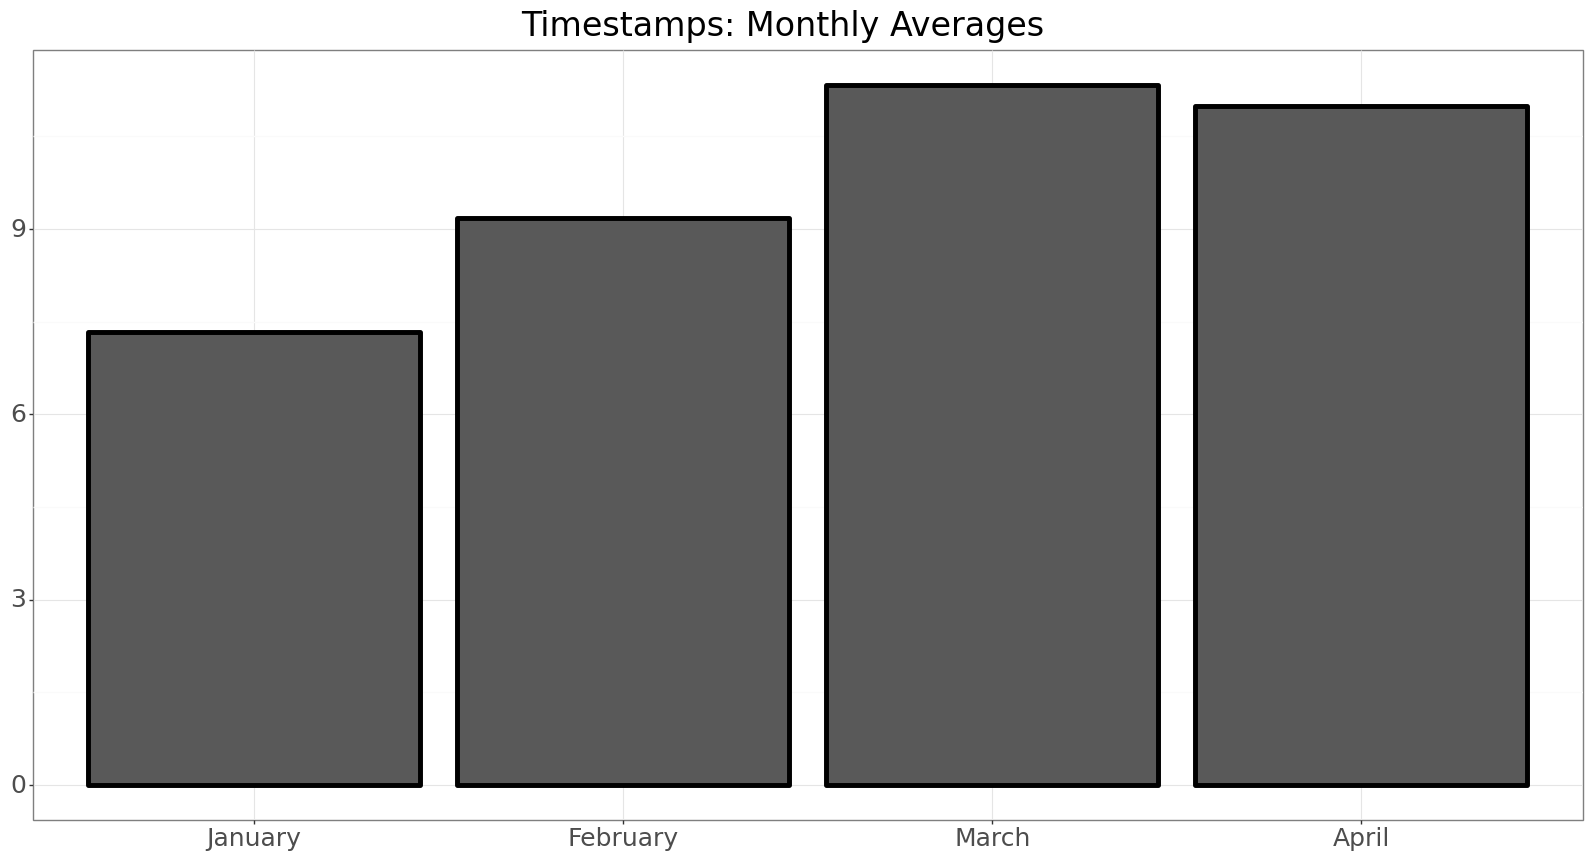

<ggplot: (118572842698)>

In [115]:
df = login_times.groupby("month").\
       agg({"timestamps": "mean"}).\
       reset_index()

(ggplot(df, aes(x = "month", y = "timestamps")) +
 geom_bar(stat = "identity", color = "black", size = 2) + 
 labs(title = "Timestamps: Monthly Averages", 
      x = "", 
      y = "") + 
 theme_bw() + 
 theme(axis_text = element_text(size = 18), 
       plot_title = element_text(size = 24)))

Each month increased over the previous. April had a slight dip from March, but is still relatively close

# Summary

* **Hourly Timestamps:** Peak times are 11am-12pm and 9pm-4am
* **Daily Timestamps:** Weekends are significantly higher than weekdays. Weekdays increase as they approach the weekend. Saturday is the highest day
* **Weekly Timestamps:** There is clear seasonality on a weekly basis
* **Monthly Timestamps:** There has been an increase each month (before a slight drop in April), but with only 4 months (January-April) there isn't sufficient data to observe any significant patterns